In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from helpers import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot

jtplot.style(theme='chesterish')
# torch.manual_seed(1)

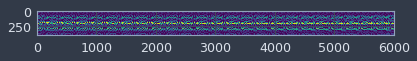

In [2]:
ySize = 180
imSize = 20
inSize = imSize ** 2
timelength = 6000
or0 = np.random.randint(360)

Input = np.zeros([inSize, timelength])

for ind in range(timelength):
    Input[:,ind] = getSineWavePatternPatch(size=[imSize,imSize],orientation=or0+0.1*ind,sf=4,
                                        wave_type='sine', radius=[8,8],
                                           center=[10,10]).flatten()


plt.imshow(Input);

Input = (Input - np.mean(Input)) / np.std(Input)

Input = Variable(torch.from_numpy(Input).type(torch.FloatTensor))


In [3]:
# Torchus

y_pred = Variable(torch.randn(ySize).clamp(-1,1))
er = Variable(torch.zeros(inSize))

# Initiliaze weights
W = Variable(torch.randn(inSize,ySize), requires_grad=True)
W.clamp(-0.1,0.1);
V = Variable(torch.randn(ySize,inSize), requires_grad=True)
V.clamp(-0.1,0.1);

R = Variable(torch.randn(ySize,ySize),requires_grad=True)
R.clamp(-0.1,0.1);

In [4]:
lr = 0.1
lrec = 0.01
optimizer = torch.optim.RMSprop([W,V],lr=lr)
# criterion = torch.nn.SmoothL1Loss(size_average=False)
criterion = nn.MSELoss()

Roptimizer = torch.optim.RMSprop([R],lr=lrec)
# criterion = torch.nn.HingeEmbeddingLoss(size_average=False)
Rcriterion = F.smooth_l1_loss

def er_loss(x,y):
    return torch.mean(torch.pow(x-y, 2))


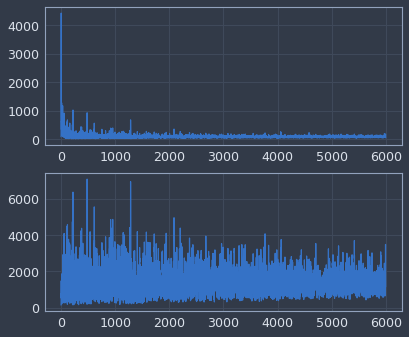

In [5]:
E = np.zeros(timelength)
Y = np.zeros([ySize,timelength]) 
RE = np.zeros(timelength)
yprev = y_pred.unsqueeze(0)
y = yprev

for t in range(timelength):
    
    optimizer.zero_grad()
    Roptimizer.zero_grad()
    
    er = torch.mm(yprev,V) - Input[:,t]
    
    y = F.tanh(torch.mm(er.detach(), W) + torch.mm(yprev.detach(), R))

#     loss = torch.sum(torch.pow(er,2))
    loss = criterion(torch.mm(yprev,V),Input[:,t])
    rloss = Rcriterion(torch.mm(er.detach(), W.detach()), torch.mm(yprev.detach(), R))
#     rloss = torch.sum(torch.pow(torch.mm(er,W)-torch.mm(yprev,R),2))
    E[t] = loss.data.numpy()
    Y[:,t]  = y.data.numpy()
    RE[t] = rloss.data.numpy()
    
    loss.backward()
    rloss.backward()
    optimizer.step()
    Roptimizer.step()
    
    yprev = y

plt.subplot(211)
plt.plot(E)
plt.subplot(212)
plt.plot(RE)

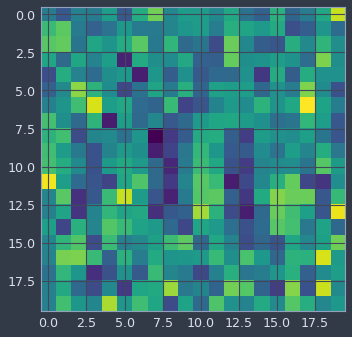

In [6]:
plt.imshow(torch.mm(yprev,V).data.numpy().reshape(20,20))

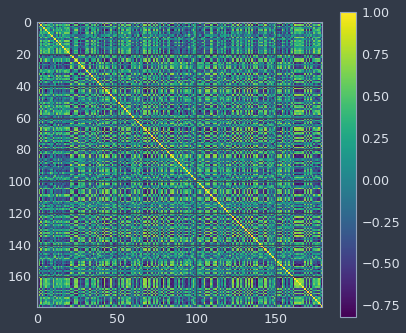

In [7]:
plt.imshow(np.corrcoef(Y)); plt.colorbar();

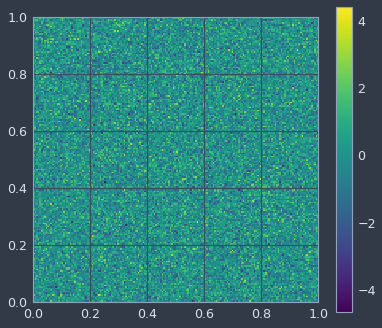

In [8]:
plt.imshow(R.data.numpy(),extent=[0,1,0,1]);
plt.colorbar();

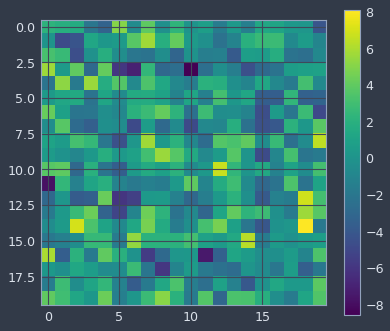

In [9]:
plt.imshow(W[:,2].data.numpy().reshape(20,20));
plt.colorbar();

In [15]:
A = np.zeros([ySize,200])
for ind in range(200):
    y = F.tanh(torch.mm(yprev,R))
    A[:,ind] = y.data.numpy()
    yprev = y

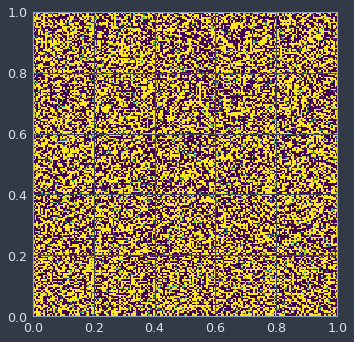

In [16]:
plt.imshow(A.T,extent=[0,1,0,1])

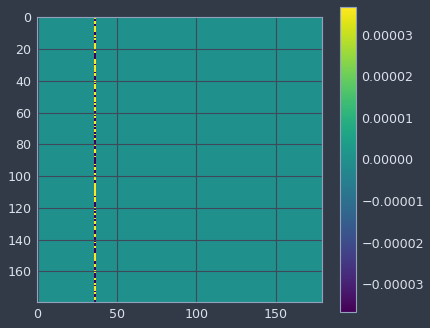

In [12]:
plt.imshow(R.grad.data.numpy()); plt.colorbar();

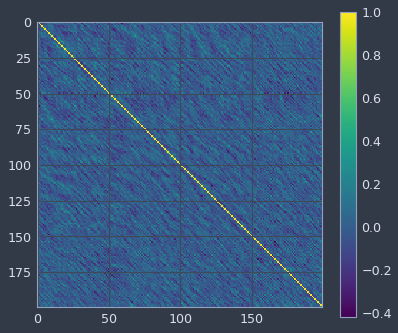

In [18]:
plt.imshow(np.corrcoef(A.T)); plt.colorbar();